In [3]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm, colors
from tqdm import tqdm

%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class Line:
    """
    Creates a line object with a speed, offset and width. Lines are drawn in an image with gen_image.
    Currently only gauss type lines work. These are all normalized such that the sum over space (x) = 1.
    With this normalization we would expect the net transport over time graph to increase by one for every line that it crosses.
    """

    def __init__(self, speed, offset, line_type="gauss", width=5, intens=1):
        self.line_type = line_type
        self.width = width
        self.speed = speed
        self.direc = np.sign(self.speed)
        self.offset = offset
        return None

    def block(self, array, speed_offset, normalize=False):
        if not normalize:
            return np.heaviside(array - speed_offset + self.width, 0.5) - np.heaviside(
                array - speed_offset - self.width, 0.5
            )
        else:
            out_arr = np.heaviside(
                array - speed_offset + self.width, 0.5
            ) - np.heaviside(array - speed_offset - self.width, 0.5)
            return out_arr / np.sum(out_arr)

    def gauss(self, array, speed_offset, normalize=False):
        return stats.norm.pdf(array, speed_offset, self.width)

    def gen_image(self, x_res, y_res, normalize=False):
        x_line = np.linspace(0, x_res - 1, x_res)
        line_pos = np.linspace(self.offset, self.offset + self.speed * y_res, y_res)
        if self.line_type == "block":
            line_img = [
                self.block(x_line, v_offset, normalize=normalize)
                for v_offset in line_pos
            ]
        elif self.line_type == "gauss":
            line_img = [
                self.gauss(x_line, v_offset, normalize=normalize)
                for v_offset in line_pos
            ]
        return line_img


# def gen_feather(img, height, zero_frac):
#     zero_thresh = int(height * zero_frac)
#     feather = np.linspace(0,1, height - zero_thresh)
#     out_img = img.copy()
#     for i in range(zero_thresh):
#         out_img[-1-i] *= 0
#     for i, j in enumerate(range(zero_thresh, height)):
#         out_img[-1-j] *= feather[i]
#     return out_img


def kymo_titles(axis, title):
    axis.set_title(title)
    axis.set_xlabel("space (x)")
    axis.set_ylabel("time (t)")
    return None


def flux_int(img, line=200):
    flux_max = np.max(abs(img.flatten()))
    [x_res, y_res] = np.shape(img)
    int_line = img.transpose()[line]
    int_plot = np.cumsum(int_line)
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout()

    ax[0].imshow(img, cmap="bwr", vmin=-1 * flux_max, vmax=flux_max)
    ax[0].vlines(line, 0, x_res - 1, colors="black")
    kymo_titles(ax[0], "Flux with integral line")

    ax[1].plot(int_plot, label="Ground Truth")
    ax[1].grid()
    ax[1].hlines(0, 0, x_res, colors="black", label="")
    ax[1].set_title("Net Transport")
    ax[1].set_xlabel("time (t)")
    ax[1].set_ylabel("transport (q)")
    ax[1].legend()
    return ax[1]


def noisy(noise_typ, image, gauss_params=[0, 0.1]):
    if noise_typ == "gauss":
        row, col = image.shape
        mean = gauss_params[0]
        var = gauss_params[1]
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col))
        gauss = gauss.reshape(row, col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row, col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1.0 - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        row, col = image.shape
        gauss = np.random.randn(row, col)
        gauss = gauss.reshape(row, col)
        noisy = image + image * gauss
        return noisy

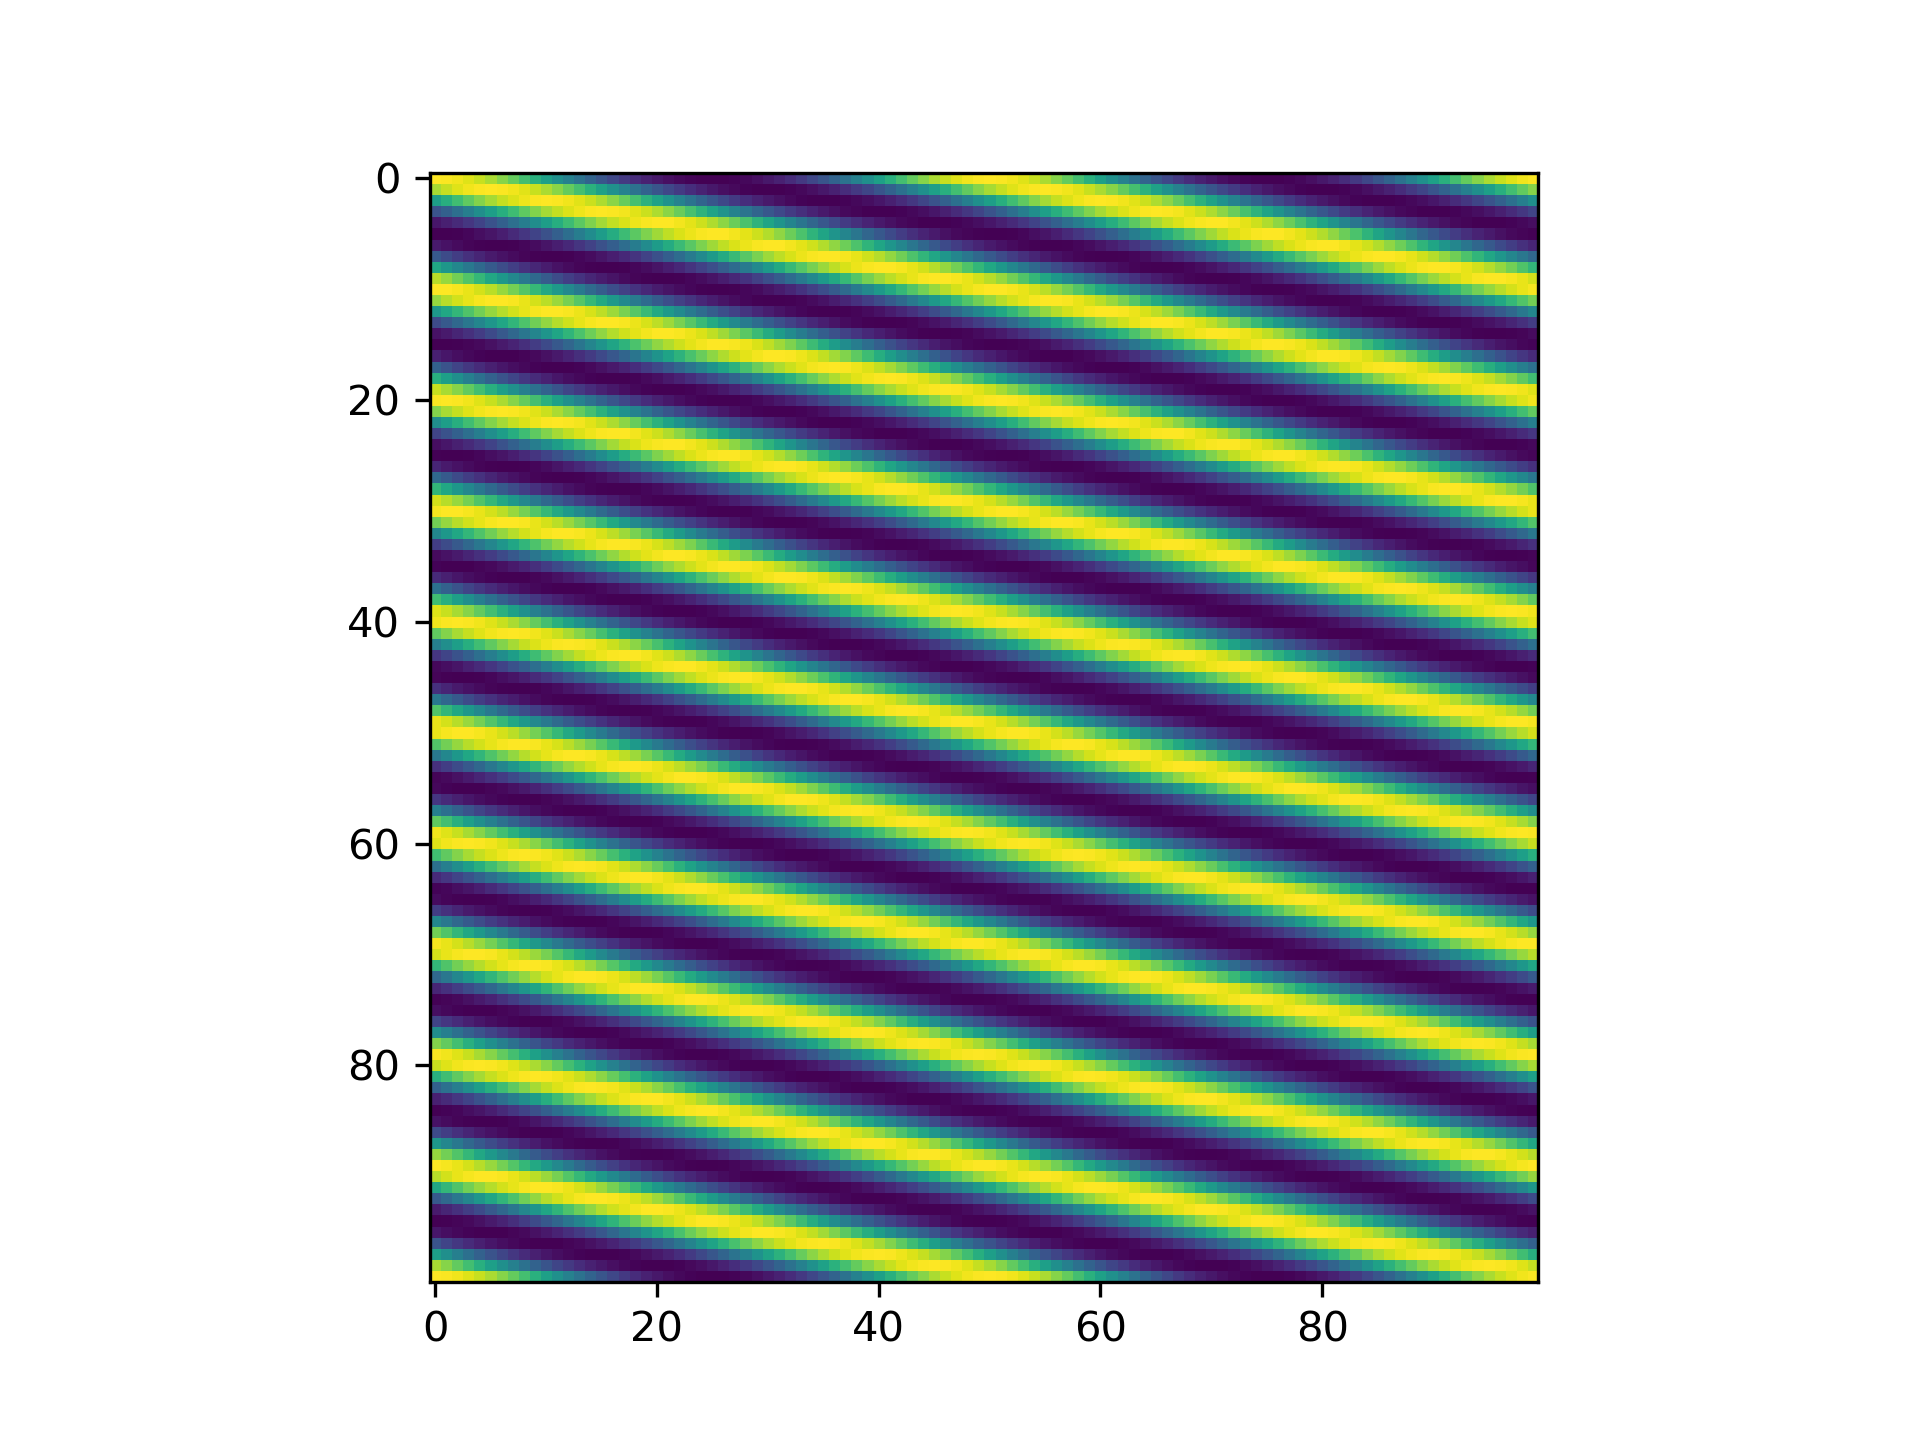

In [19]:
import imageio

line = Line(5, 10, width=2)
images = [
    Line(5, 50 * (offset - 10), width=10).gen_image(100, 100) for offset in range(20)
]
image = np.sum(images, axis=0)
fig, ax = plt.subplots()
ax.imshow(image)
imageio.imwrite("test.tif", image)

# Big Line Test doc

This document generates lines for analysis of the kymograph flux calculation algorithms. 

## Line Gen
The next piece of code generates these lines and sets up the ground truth for the flux calculation.

In [3]:
def extract_net_transport(line, orig_img, recon_img, margin=10):
    int_line = orig_img.transpose()[line][margin:-margin]
    int_plot = np.cumsum(int_line)
    fourier_adj_int = np.nancumsum(recon_img.transpose()[line][margin:-margin])
    return np.array(
        [int_plot[-1] - int_plot[0], fourier_adj_int[-1] - fourier_adj_int[0]]
    )


# def do_line_test(x_res          = 300,
#                  y_res          = 400,
#                  nr_forw_lines  = 10,
#                  nr_back_lines  = 10,
#                  nr_stat_lines  = 10,
#                  forw_intens    = 1.0,
#                  back_intens    = 1.0,
#                  stat_intens    = 1.0,
#                  forw_speed     = 1.0,
#                  back_speed     = 1.0,
#                  forw_width     = 1.0,
#                  back_width     = 1.0,
#                  stat_width     = 1.0,
#                  forw_speed_var = 1.0,
#                  back_speed_var = 1.0,
#                  forw_width_var = 1.0,
#                  back_width_var = 1.0,
#                  stat_width_var = 1.0,
#                  noise_thresh   = 0.01,
#                  speed_thresh   = 10,
#                  display_figs   = False):


def do_line_test(pd, noise_thresh=0.01, speed_thresh=10, display_figs=False):

    x_res = int(pd.loc["x_res"])
    y_res = int(pd.loc["y_res"])
    nr_forw_lines = int(pd.loc["nr_forw_lines"])
    nr_back_lines = int(pd.loc["nr_back_lines"])
    nr_stat_lines = int(pd.loc["nr_stat_lines"])
    forw_intens = pd.loc["forw_intens"]
    back_intens = pd.loc["back_intens"]
    stat_intens = pd.loc["stat_intens"]
    forw_speed = pd.loc["forw_speed"]
    back_speed = pd.loc["back_speed"]
    forw_width = pd.loc["forw_width"]
    back_width = pd.loc["back_width"]
    stat_width = pd.loc["stat_width"]
    forw_speed_var = pd.loc["forw_speed_var"]
    back_speed_var = pd.loc["back_speed_var"]
    forw_width_var = pd.loc["forw_width_var"]
    back_width_var = pd.loc["back_width_var"]
    stat_width_var = pd.loc["stat_width_var"]

    img_stack = []
    img_forw_stack = []
    img_back_stack = []
    flux_stack = []
    flux_stack_back = []
    flux_stack_forw = []
    params_forw = np.array(
        [
            np.random.normal(forw_speed, forw_speed_var, size=nr_forw_lines),
            np.random.uniform(-y_res, x_res, nr_forw_lines),
            abs(np.random.normal(forw_width, forw_width_var, size=nr_forw_lines)),
        ]
    ).T
    params_back = np.array(
        [
            np.random.normal(-1 * back_speed, back_speed_var, size=nr_back_lines),
            np.random.uniform(0, x_res + y_res, nr_back_lines),
            abs(np.random.normal(back_width, back_width_var, size=nr_back_lines)),
        ]
    ).T
    #     params_back = np.random.rand(nr_back_lines, 3)
    params_stat = np.random.rand(nr_stat_lines, 3)

    for i in range(nr_forw_lines):
        params_proc = params_forw
        line = Line(params_proc[i][0], params_proc[i][1], width=params_proc[i][2])
        img_forw = np.array(line.gen_image(x_res, y_res, normalize=True)) * forw_intens
        img_stack.append(img_forw)
        img_forw_stack.append(img_forw)
        flux_img_forw = img_forw * params_proc[i][0]
        flux_stack_forw.append(flux_img_forw)
        flux_stack.append(flux_img_forw)

    for i in range(nr_back_lines):
        params_proc = params_back
        line = Line(params_proc[i][0], params_proc[i][1], width=params_proc[i][2])
        img_back = np.array(line.gen_image(x_res, y_res, normalize=True)) * back_intens
        img_stack.append(img_back)
        img_back_stack.append(img_back)
        flux_img_back = img_back * params_proc[i][0]
        flux_stack_back.append(flux_img_back)
        flux_stack.append(flux_img_back)

    for i in range(nr_stat_lines):
        params = np.random.rand(3)
        params_proc = (
            0,
            params_stat[i][1] * x_res,
            (params_stat[i][2] + stat_width) * stat_width_var,
        )
        line = Line(params_proc[0], params_proc[1], width=params_proc[2])
        img_stat = np.array(line.gen_image(x_res, y_res, normalize=True)) * stat_intens
        img_stack.append(img_stat)
        flux_img_stat = img_stat * params_proc[0]
        flux_stack.append(flux_img_stat)

    tot_img = np.sum(img_stack, axis=0)
    tot_img = noisy("gauss", tot_img, gauss_params=[0, 0.0001])
    tot_img_forw = np.sum(img_forw_stack, axis=0)
    tot_img_back = np.sum(img_back_stack, axis=0)
    tot_flux = np.sum(flux_stack, axis=0)
    tot_flux_forw = np.sum(flux_stack_forw, axis=0)
    tot_flux_back = np.sum(flux_stack_back, axis=0)
    img_max = np.max(abs(tot_img.flatten()))
    flux_max = np.max(abs(tot_flux.flatten()))
    kymo_anal = Kymo_edge_analysis(kymo=tot_img)
    forw_thresh, back_thresh = kymo_anal.fourier_kymo(1, test_plots=False)
    #     forw_back = np.add(forw, back)
    #     forw_thresh = forw
    #     back_thresh = back
    #     forw_back_thresh = np.add(forw_thresh, back_thresh)
    speeds, times = kymo_anal.test_GST(
        7,
        w_start=5,
        C_thresh=0.95,
        C_thresh_falloff=0.0,
        blur_size=7,
        preblur=True,
        speed_thresh=speed_thresh,
        plots=False,
    )
    #     spd_max = np.nanmax(abs(speeds.flatten()))
    spds_forw = speeds[0][1]
    spds_back = speeds[0][0]
    #     spds_tot = np.nansum(np.dstack((spds_back,spds_forw)),2)
    flux_tot = np.nansum(
        (
            np.prod((spds_forw, forw_thresh[0]), 0),
            np.prod((spds_back, back_thresh[0]), 0),
        ),
        0,
    )

    trans_plots = np.array(
        [
            extract_net_transport(line, tot_flux, flux_tot)
            for line in range(5, flux_tot.shape[1] - 5)
        ]
    ).transpose()

    if display_figs:
        fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
        ax[0].imshow(tot_img)
        kymo_titles(ax[0], "Original kymo")
        # ax[1].imshow(feather_img)
        # kymo_titles(ax[1], "Feathered kymo")
        flx = ax[1].imshow(tot_flux, cmap="bwr", vmin=-1 * flux_max, vmax=flux_max)
        kymo_titles(ax[1], "Flux kymo")
        cbar = plt.colorbar(flx, fraction=0.056, pad=0.02)
        cbar.ax.set_ylabel("Speed*Intensity", rotation=270)

        fig.tight_layout()

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        for i in [0, 1]:
            thi = ax[i].imshow(
                [tot_flux_forw, tot_flux_back][i],
                cmap="bwr",
                vmin=-1 * flux_max,
                vmax=flux_max,
            )
            ax[i].set_title("Flux {}".format(["forward", "backward"][i]))

        cbar2 = plt.colorbar(thi, fraction=0.056, pad=0.02)
        cbar2.ax.set_ylabel("Speed*Intensity", rotation=270)

        fig.tight_layout()
    #     print(f'Pointwise error mean \t{np.mean((trans_plots[1] - trans_plots[0])):.4}')
    #     print(f'Pointwise error var \t {np.std((trans_plots[1] - trans_plots[0])):.4}')

    return np.mean(trans_plots[1]), np.mean(trans_plots[0])

In [14]:
d = {
    "x_res": [400],
    "y_res": [800],
    "nr_forw_lines": [50],
    "nr_back_lines": [50],
    "nr_stat_lines": [10],
    "forw_intens": [10.0],
    "back_intens": [10.0],
    "stat_intens": [10.0],
    "forw_speed": [1.0],
    "back_speed": [1.0],
    "forw_width": [9.0],
    "back_width": [9.0],
    "stat_width": [1.0],
    "forw_speed_var": [0.3],
    "back_speed_var": [0.3],
    "forw_width_var": [1.0],
    "back_width_var": [2.0],
    "stat_width_var": [2.0],
}

dataframe = pd.DataFrame(d)

nr_tests = 128 * 64

expo_linspace = np.array(np.linspace(1, 1000, nr_tests))

dataframe.loc[0, "nr_forw_lines"] = int(expo_linspace[0])
dataframe.loc[0, "nr_back_lines"] = int(1001 - expo_linspace[0])
# dataframe.loc[0, 'forw_speed_var'] = 1.0

for i in range(nr_tests - 1):
    dataframe.loc[len(dataframe.index)] = dataframe.iloc[0]
    dataframe.loc[i + 1, "nr_forw_lines"] = int(expo_linspace[i + 1])
    dataframe.loc[i + 1, "nr_back_lines"] = int(1001 - expo_linspace[i + 1])
#     dataframe.loc[i+1, 'forw_speed_var'] = (9-i)/10

dataframe["nr_forw_lines"] = np.array(np.random.uniform(20, 200, nr_tests), dtype=int)
dataframe["nr_back_lines"] = np.array(np.random.uniform(20, 200, nr_tests), dtype=int)
dataframe["nr_stat_lines"] = np.array(np.random.uniform(1, 30, nr_tests), dtype=int)
dataframe["forw_intens"] = np.array(abs(np.random.normal(10, 4, nr_tests)))
dataframe["back_intens"] = np.array(abs(np.random.normal(10, 4, nr_tests)))
dataframe["stat_intens"] = np.array(abs(np.random.normal(10, 4, nr_tests)))
dataframe["forw_speed"] = np.array(np.random.normal(0.05, 0.1, nr_tests))
dataframe["back_speed"] = np.array(np.random.normal(0.05, 0.1, nr_tests))
dataframe["forw_width"] = np.array(np.random.normal(17, 5, nr_tests))
dataframe["back_width"] = np.array(np.random.normal(17, 5, nr_tests))
dataframe["stat_width"] = np.array(np.random.normal(17, 5, nr_tests))
dataframe["forw_speed_var"] = abs(np.array(np.random.normal(0.1, 0.2, nr_tests)))
dataframe["back_speed_var"] = abs(np.array(np.random.normal(0.1, 0.2, nr_tests)))
dataframe["forw_width_var"] = abs(np.array(np.random.normal(3, 1, nr_tests)))
dataframe["back_width_var"] = abs(np.array(np.random.normal(3, 1, nr_tests)))
dataframe["stat_width_var"] = abs(np.array(np.random.normal(3, 1, nr_tests)))

test_title = f"Scatterplot of transport tests"
test_xaxis = "Ground Truth Transport"

print(test_title)

dataframe

Scatterplot of transport tests


x_res  y_res  nr_forw_lines  nr_back_lines  nr_stat_lines  forw_intens  \
0     400.0  800.0            158            190             28    15.214312   
1     400.0  800.0            155            107             10     7.425493   
2     400.0  800.0             39             27             12     5.579204   
3     400.0  800.0             51            124             12    10.497467   
4     400.0  800.0             68             38              1    10.002544   
...     ...    ...            ...            ...            ...          ...   
8187  400.0  800.0             46            125             19     8.596281   
8188  400.0  800.0             25            149             26    10.130636   
8189  400.0  800.0             51            164              5    10.568385   
8190  400.0  800.0            125             86              7     5.715379   
8191  400.0  800.0             94            161             23    15.295309   

      back_intens  stat_intens  forw_speed  back_speed  forw_width  \
0        4.352373     3.115261    0.020217    0.092201   18.874321   
1        9.711593     9.752818    0.106902   -0.047302   17.362204   
2        7.092075    14.460700    0.003714    0.033997   23.854947   
3       13.010968     4.416321   -0.065324    0.019448   12.828210   
4       14.886193    16.090599   -0.236308    0.068775   10.969857   
...           ...          ...         ...         ...         ...   
8187     5.595030     1.342147   -0.106581   -0.027753   17.468717   
8188     8.527008     6.307649    0.191180    0.030293   22.241550   
8189    17.580764     2.323826    0.037211    0.040725   20.131053   
8190    10.134368     1.031772   -0.125680    0.084023   13.112906   
8191     7.117723     5.832864    0.033585    0.087739   26.258335   

      back_width  stat_width  forw_speed_var  back_speed_var  forw_width_var  \
0      15.893110   25.276053        0.503921        0.103416        2.266540   
1      17.238923   23.401669        0.062747        0.031812        2.443708   
2       4.153309   26.090928        0.652357        0.107395        1.887959   
3      22.328673   26.363459        0.633753        0.026176        3.768331   
4      22.699416   14.447643        0.345457        0.284478        3.318847   
...          ...         ...             ...             ...             ...   
8187    6.622584   16.810097        0.016715        0.037457        1.281085   
8188   20.361393    5.709893        0.147941        0.152278        1.279114   
8189   18.846268   18.354299        0.101468        0.273877        2.914369   
8190   21.766633   10.502814        0.188530        0.077469        4.426270   
8191    5.332608   25.408243        0.516178        0.184163        2.823678   

      back_width_var  stat_width_var  
0           1.695715        2.196957  
1           3.697719        3.239181  
2           1.426763        2.911379  
3           3.057289        3.769337  
4           4.909646        2.430688  
...              ...             ...  
8187        4.271229        3.932285  
8188        2.964422        2.685339  
8189        4.121887        2.329077  
8190        3.182660        2.053492  
8191        2.786795        2.640889  

[8192 rows x 18 columns]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.54s/it]


est_mean  est_var    gtr_mean  gtr_var
0  480.068120      NaN  180.725451      NaN
1   78.326012      NaN  102.807627      NaN
2   64.461680      NaN   37.344563      NaN
3  186.029755      NaN   13.914192      NaN
4  -93.955448      NaN -104.074315      NaN
5   -5.789939      NaN   -4.231412      NaN
6 -766.083683      NaN -701.874431      NaN
7  231.247609      NaN  208.944507      NaN
8 -132.826510      NaN -106.747176      NaN
9   96.095403      NaN   59.042214      NaN

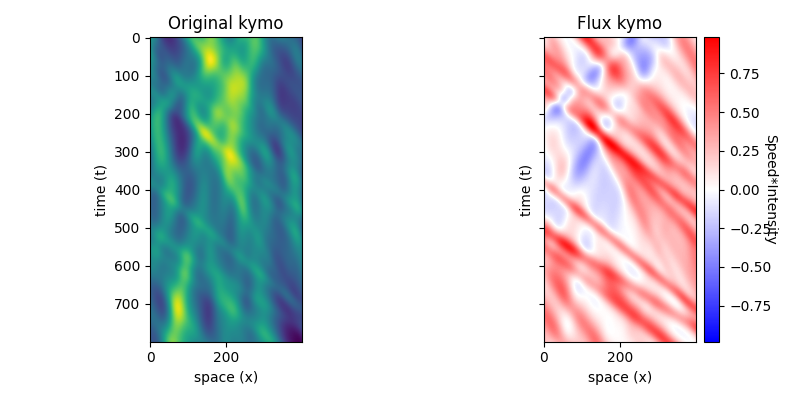

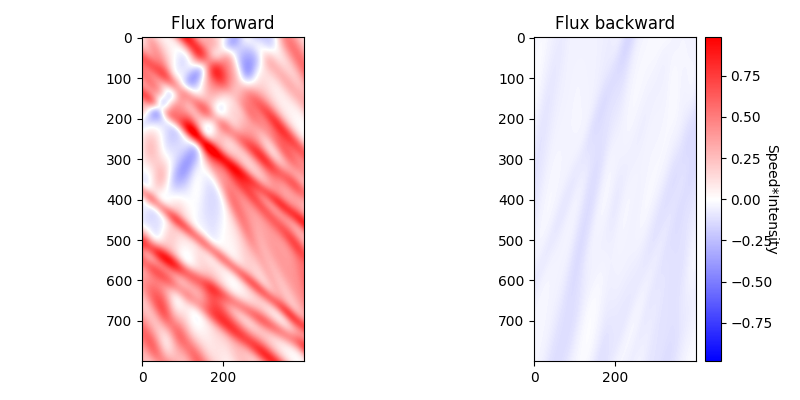

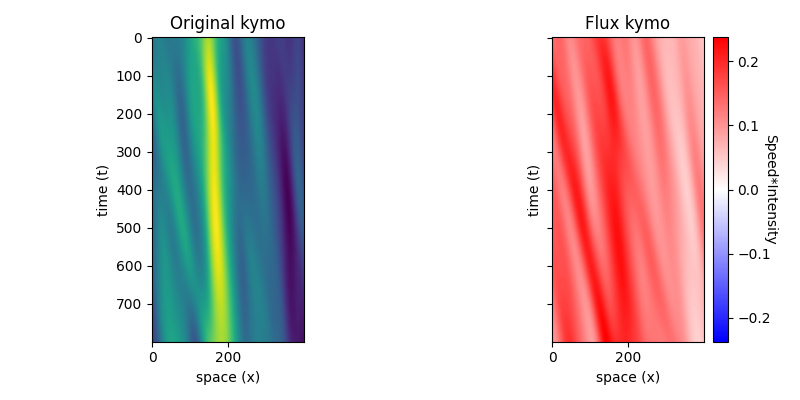

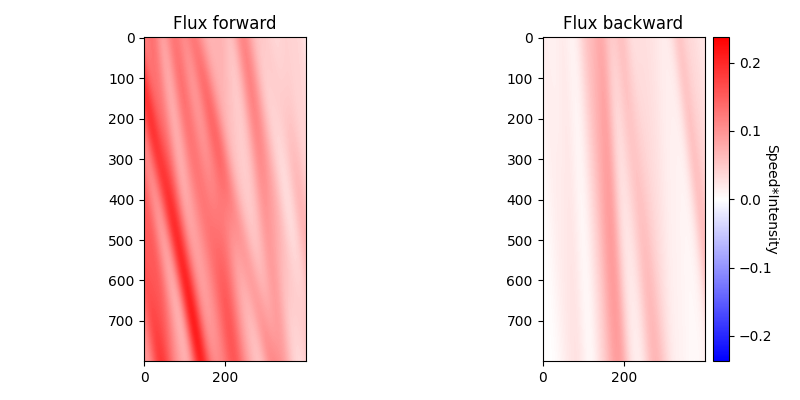

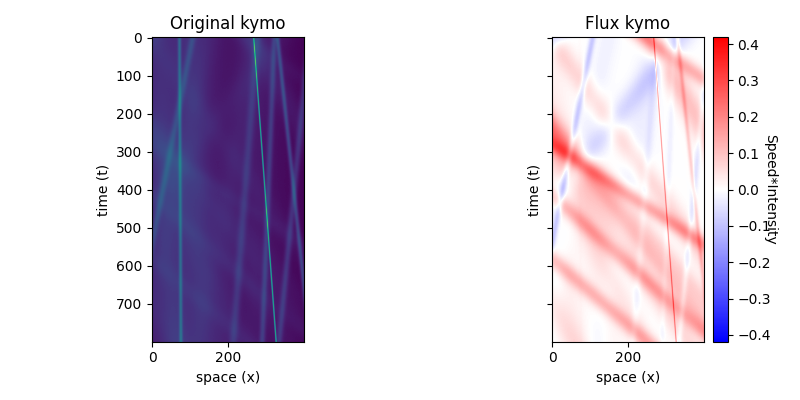

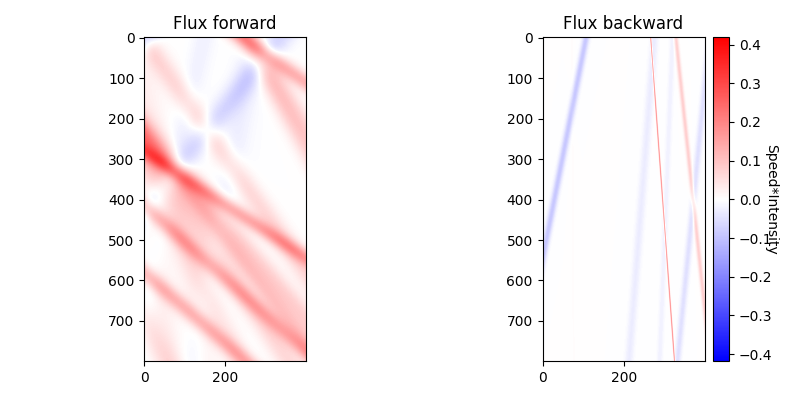

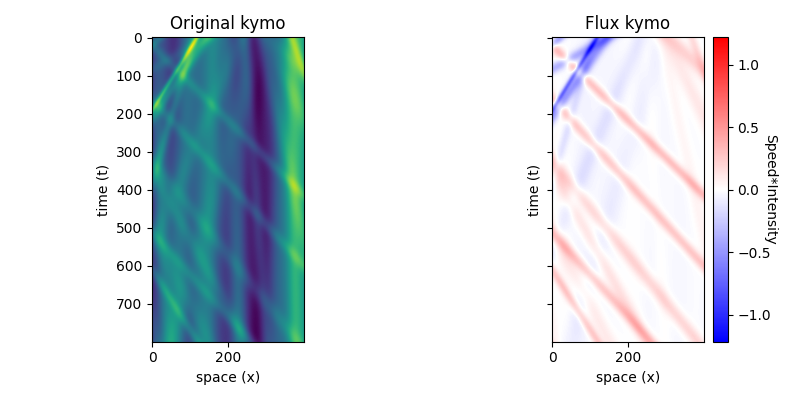

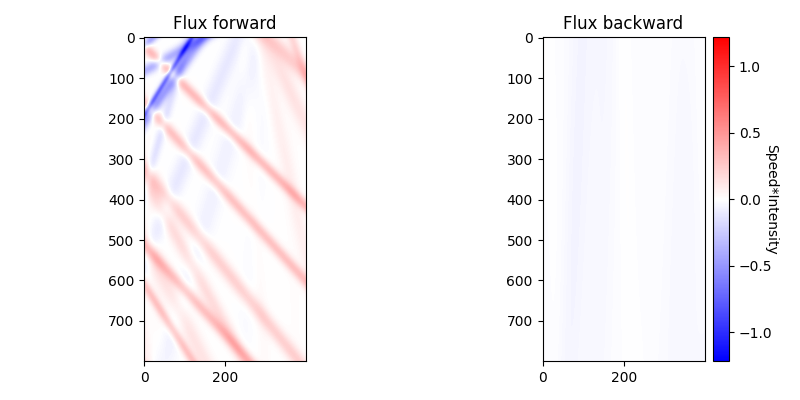

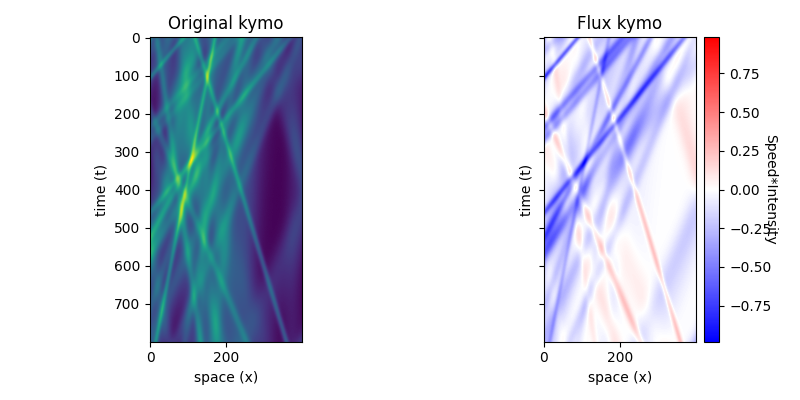

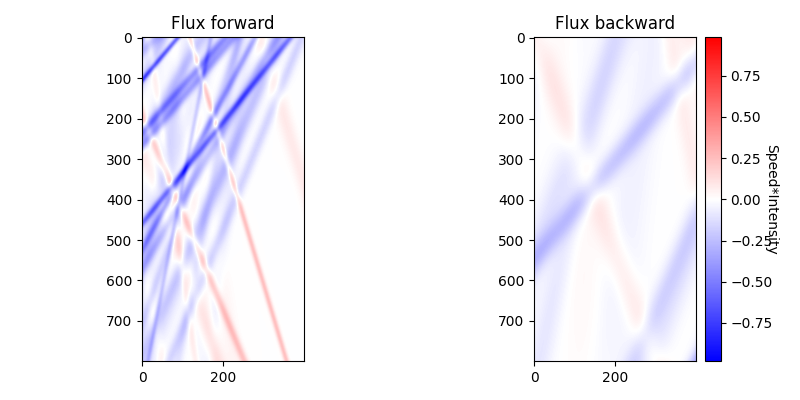

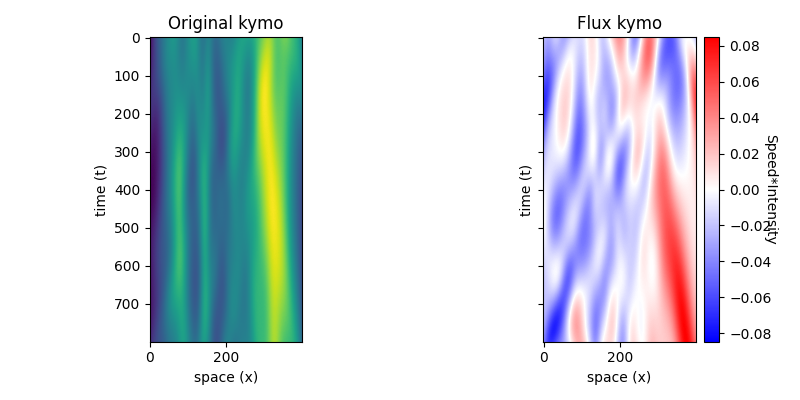

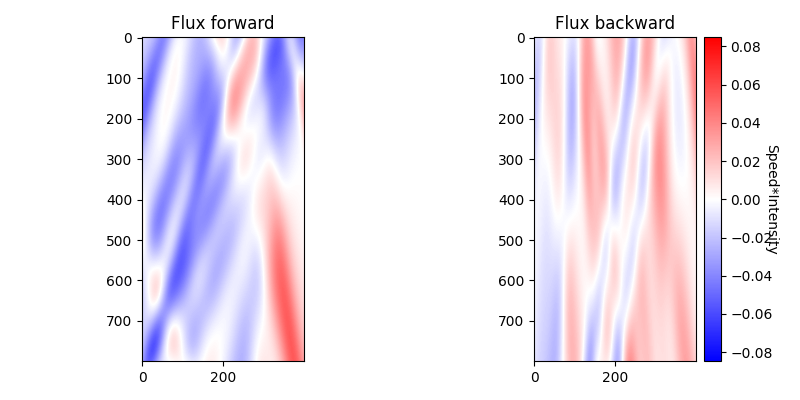

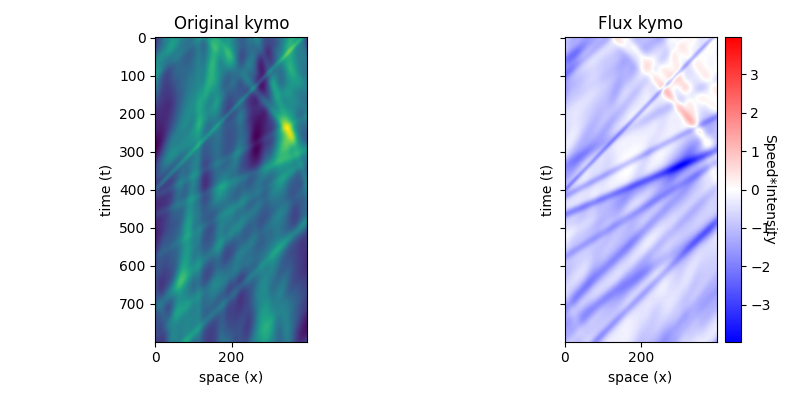

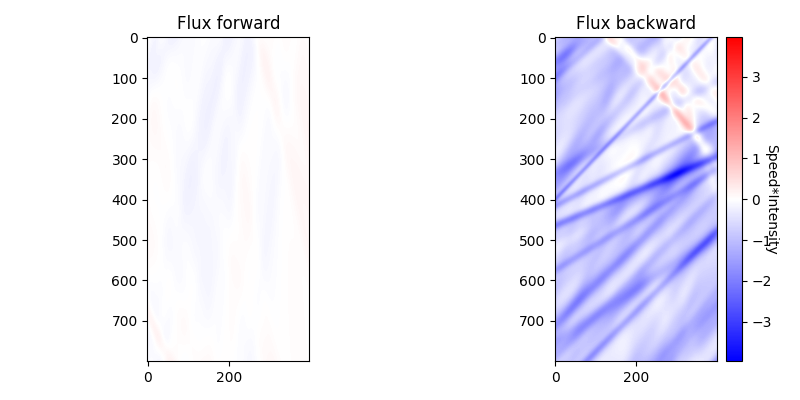

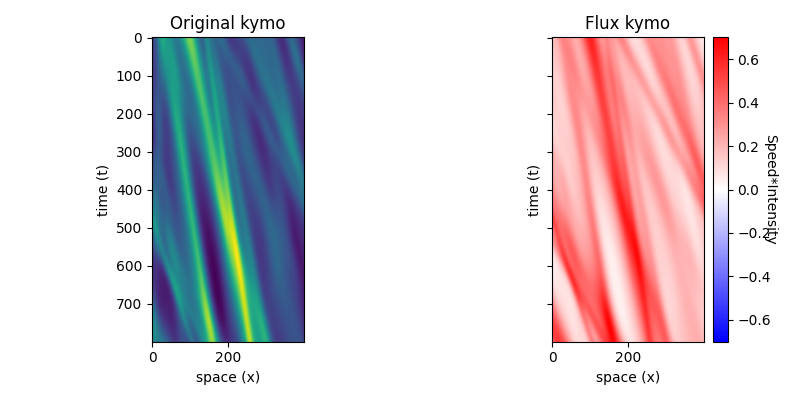

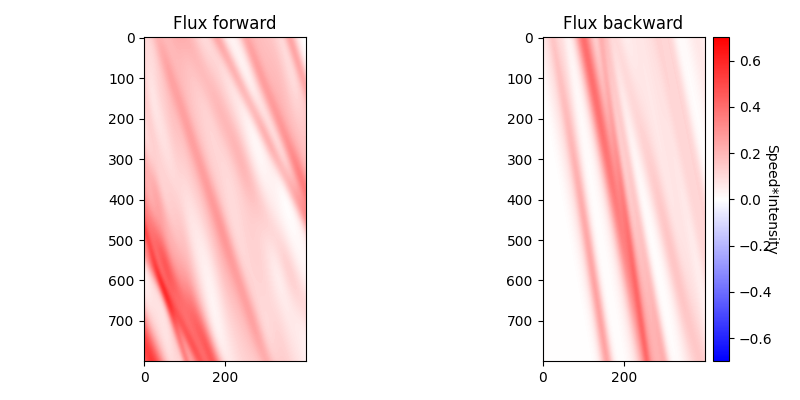

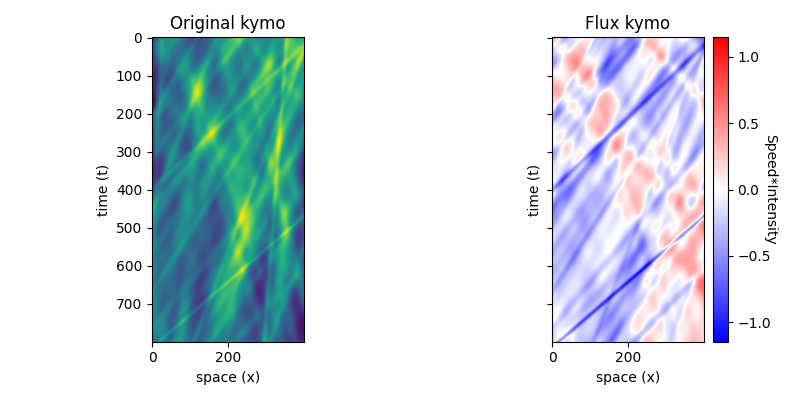

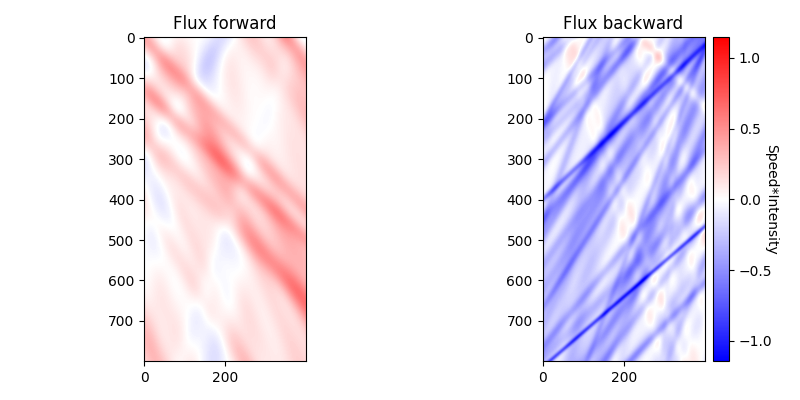

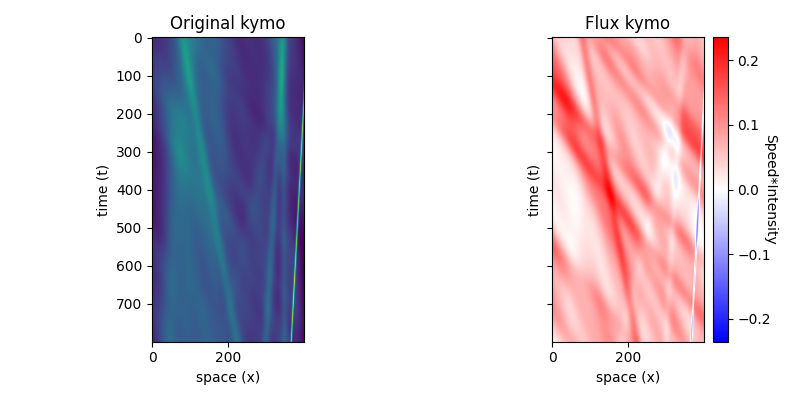

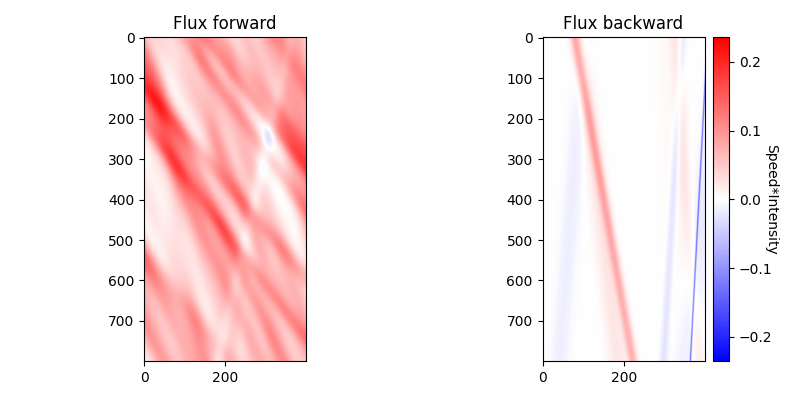

In [15]:
results = np.zeros((4, 10))

for j in range(10):
    t = {}
    for i in tqdm(range(1)):
        t[f"test_{i}"] = do_line_test(dataframe.iloc[j], display_figs=True)
    #         print(t[f'test_{i}'])
    testframe = pd.DataFrame(t)
    results[0][j] = testframe.mean(axis=1).iloc[0]
    results[1][j] = testframe.std(axis=1).iloc[0]
    results[2][j] = testframe.mean(axis=1).iloc[1]
    results[3][j] = testframe.std(axis=1).iloc[1]

#     print(testframe.mean(axis=1).iloc[0])

results_pd = {
    "est_mean": results[0],
    "est_var": results[1],
    "gtr_mean": results[2],
    "gtr_var": results[3],
}
r_pd = pd.DataFrame(results_pd)
r_pd

# print(testframe.mean(axis=1))
# print(testframe.std(axis=1))

In [ ]:
display_figs = False
# Display debug figures (False for faster performance)
noise_thresh = 0.01
# Remove low intensity background noise from kymograph, needs to change once we're dealing with actual pixel values
speed_thresh = 10.0
# Puts an upper boundary to the function that finds speeds

nr_forw_lines = 25
nr_back_lines = 25
nr_stat_lines = 0
nr_total_lines = nr_forw_lines + nr_back_lines

x_res_kymo = 300
y_res_kymo = 200

# lines_left = []
# lines_right=  []
img_stack = []
img_forw_stack = []
img_back_stack = []
flux_stack = []
flux_stack_back = []
flux_stack_forw = []

forw_spd_adjust = 1.0
back_spd_adjust = 1.0

params_forw = np.random.rand(nr_forw_lines, 3)

for i in range(nr_forw_lines):
    params_proc = (
        (params_forw[i][0] + 0.5) * forw_spd_adjust,
        int(params_forw[i][1] * x_res_kymo / 2)
        - int((params_forw[i][0]) * forw_spd_adjust * x_res_kymo),
        (params_forw[i][2] + 0.5) * 9,
    )
    #                    5)
    line = Line(params_proc[0], params_proc[1], width=params_proc[2])
    img_forw = np.array(line.gen_image(x_res_kymo, y_res_kymo, normalize=True)) * 25
    img_stack.append(img_forw)
    img_forw_stack.append(img_forw)
    flux_img_forw = img_forw * params_proc[0]
    flux_stack_forw.append(flux_img_forw)
    flux_stack.append(flux_img_forw)

for i in range(nr_back_lines):
    params = np.random.rand(3)
    params_proc = (
        (params[0] - 1.5) * back_spd_adjust,
        int(params[1] * x_res_kymo / 2)
        - int((params[0] - 1.0) * back_spd_adjust * x_res_kymo),
        (params[2] + 0.5) * 9,
    )
    #                    5)
    line = Line(params_proc[0], params_proc[1], width=params_proc[2])

    img_back = np.array(line.gen_image(x_res_kymo, y_res_kymo, normalize=True)) * 25
    img_stack.append(img_back)
    img_back_stack.append(img_back)
    flux_img_back = img_back * params_proc[0]
    flux_stack_back.append(flux_img_back)
    flux_stack.append(flux_img_back)

for i in range(nr_stat_lines):
    params = np.random.rand(3)
    params_proc = (0, params[1] * x_res_kymo, (params[2] + 0.5) * 9)
    line = Line(params_proc[0], params_proc[1], width=params_proc[2])
    img_stat = np.array(line.gen_image(x_res_kymo, y_res_kymo, normalize=True)) * 4
    img_stack.append(img_stat)
    flux_img_stat = img_stat * params_proc[0]
    flux_stack.append(flux_img_stat)

tot_img = np.sum(img_stack, axis=0)

tot_img = noisy("gauss", tot_img, gauss_params=[0, 0.001])

tot_img_forw = np.sum(img_forw_stack, axis=0)
tot_img_back = np.sum(img_back_stack, axis=0)
tot_flux = np.sum(flux_stack, axis=0)
tot_flux_forw = np.sum(flux_stack_forw, axis=0)
tot_flux_back = np.sum(flux_stack_back, axis=0)

print(tot_flux_forw.shape)
print(tot_flux_back.shape)

img_max = np.max(abs(tot_img.flatten()))
flux_max = np.max(abs(tot_flux.flatten()))

# feather_img = gen_feather(tot_img, 40, 0.2)

In [ ]:
kymo_anal = Kymo_edge_analysis(kymo=tot_img)
forw, back = kymo_anal.fourier_kymo(1, test_plots=False)
forw_back = np.add(forw, back)
forw_thresh = forw
back_thresh = back
forw_back_thresh = np.add(forw_thresh, back_thresh)

speeds, times = kymo_anal.test_GST(
    7,
    w_start=5,
    C_thresh=0.95,
    C_thresh_falloff=0.0,
    blur_size=7,
    preblur=True,
    speed_thresh=10,
    plots=False,
)

spd_max = np.nanmax(abs(speeds.flatten()))
spds_forw = speeds[0][1]
spds_back = speeds[0][0]

spds_tot = np.nansum(np.dstack((spds_back, spds_forw)), 2)
flux_tot = np.nansum(
    (np.prod((spds_forw, forw_thresh[0]), 0), np.prod((spds_back, back_thresh[0]), 0)),
    0,
)

In [ ]:
# print(extract_net_transport(209, flux_tot, tot_flux).shape)

fig, ax = plt.subplots(1, 2)
ax[0].set_xlabel("space (x)")
ax[0].set_ylabel("Normalized transport error")


# print(trans_plots.shape)

ax[0].plot(
    (trans_plots[1] - trans_plots[0]) / nr_total_lines,
    color="black",
    alpha=0.5,
    label="error",
)
ax[0].set_ylim(-1, 1)
print(f"Pointwise error mean \t{np.mean((trans_plots[1] - trans_plots[0])):.4}")
print(f"Pointwise error var \t {np.std((trans_plots[1] - trans_plots[0])):.4}")
ax[1].set_ylabel("Net transport (q)")
ax[1].plot(trans_plots[1], label="Estimation")
ax[1].plot(trans_plots[0], label="Ground Truth")
ax[1].set_ylim(-1 * nr_total_lines, nr_total_lines)
ax[1].legend()
# ax.set_ylim([-5, 5])
# ax.hlines(1, 0, 299, label='Desired error')
ax[0].legend()
fig.tight_layout()

line_interest = 100
fig, ax = plt.subplots()
ax.plot(
    np.nancumsum(flux_tot.transpose()[line_interest][25:-25]) / nr_total_lines,
    label="Estimation",
)
ax.plot(
    np.nancumsum(tot_flux.transpose()[line_interest][25:-25]) / nr_total_lines,
    label="Ground Truth",
)
ax.set_title("Example line integral")
ax.set_ylabel("Normalized net transport")
ax.set_xlabel("time ($t$)")
ax.legend()
fig.tight_layout()

## Fourier Filtering
Here the original image is filtered to extract the forward and backward speeds. The filtering will lose the baseline, which means the values in the images are balanced around zero. To account for this, the average error of the reconstructed image with the original image is used to restore the proper values.

## Speed extraction
Now that the images are filtered, both forward an backward filtered images can be used for speed extraction. These can then be added with each other to get the general flux of the kymographs.

### TRANSPORT:
We're getting towards the end, here we check to see how line integrals are doing. We are plotting the ground truth net transport, the transport with just the fourier filtered images (speed is assumed to be 1), and the integral over the flux images that were created. 

In [ ]:
if display_figs:
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
    ax[0].imshow(tot_img)
    kymo_titles(ax[0], "Original kymo")
    # ax[1].imshow(feather_img)
    # kymo_titles(ax[1], "Feathered kymo")
    flx = ax[1].imshow(tot_flux, cmap="bwr", vmin=-1 * flux_max, vmax=flux_max)
    kymo_titles(ax[1], "Flux kymo")
    cbar = plt.colorbar(flx, fraction=0.056, pad=0.02)
    cbar.ax.set_ylabel("Speed*Intensity", rotation=270)

    fig.tight_layout()

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    for i in [0, 1]:
        thi = ax[i].imshow(
            [tot_flux_forw, tot_flux_back][i],
            cmap="bwr",
            vmin=-1 * flux_max,
            vmax=flux_max,
        )
        ax[i].set_title("Flux {}".format(["forward", "backward"][i]))

    cbar2 = plt.colorbar(thi, fraction=0.056, pad=0.02)
    cbar2.ax.set_ylabel("Speed*Intensity", rotation=270)

    fig.tight_layout()

In [ ]:
if display_figs:
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    col = [None] * 4
    for i in [0, 1]:
        col[i] = ax[0][i].imshow([back[0], forw[0]][i], vmin=0, vmax=img_max)
        col[i + 2] = ax[1][i].imshow(
            [tot_img_forw, tot_img_back][i], vmin=0, vmax=img_max
        )
        ax[0][i].set_title("{} filtered kymo".format(["Back", "Forward"][i]))
        ax[1][i].set_title("{} original kymo".format(["Back", "Forward"][i]))

        plt.colorbar(col[i], fraction=0.056, pad=0.02)
        plt.colorbar(col[i + 2], fraction=0.056, pad=0.02)

In [ ]:
if display_figs:
    fig, ax = plt.subplots(2, 3, sharey="row", figsize=(10, 6))
    fig.suptitle("Speeds and speeds * intensities")
    for i in range(3):
        spds = ax[0][i].imshow(
            [spds_forw, spds_back, spds_tot][i],
            vmin=-1 * spd_max,
            vmax=spd_max,
            cmap="bwr",
        )
        ax[0][i].set_title("{} speeds".format(["Forward", "Backward", "Total"][i]))
        ax[i % 2][0].set_ylabel("time (t)")
        ax[0][i].set_xlabel("space (x)")
        ax[1][i].set_xlabel("space (x)")

        spdints = ax[1][i].imshow(
            [
                np.prod((spds_forw, forw_thresh[0]), 0),
                np.prod((spds_back, back_thresh[0]), 0),
                flux_tot,
            ][i],
            vmin=-1 * flux_max,
            vmax=flux_max,
            cmap="bwr",
        )
        ax[1][i].set_title("{} flux".format(["Forward", "Backward", "Total"][i]))

    cbar3 = plt.colorbar(spds, fraction=0.056, pad=0.02)
    cbar3 = plt.colorbar(spdints, fraction=0.056, pad=0.02)
    fig.tight_layout()

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 3))
    for i in range(2):
        comp = ax[i].imshow(
            [flux_tot, tot_flux][i], vmin=-1 * flux_max, vmax=flux_max, cmap="bwr"
        )
        ax[i].set_title(
            "Flux {}".format(["reconstructed", "ground truth", "ratio log error"][i])
        )
    plt.colorbar(comp, fraction=0.056, pad=0.02)

    fig, ax = plt.subplots()
    err_hist = ax.hist(
        (abs(flux_tot) / abs(tot_flux)).flatten(),
        bins=np.logspace(-5, 5, 50),
        log=False,
    )
    ax.set_xscale("log")
    fold_max = (
        err_hist[1][np.argmax(err_hist[0][1:])]
        + err_hist[1][np.argmax(err_hist[0][1:]) + 1]
    ) / 2
    ax.set_title("Error Ratio Histo (non-zero max at fold {:.4})".format(fold_max))
    ax.set_xlabel("fold change")
    ax.set_ylabel("log frequency")

In [ ]:
if display_figs:
    fig, ax = plt.subplots(1, 2, figsize=(8, 16))
    for i in [0, 1]:
        ax[i].imshow([spds_tot, flux_tot][i], vmin=-spd_max, vmax=spd_max, cmap="bwr")
        ax[i].set_title("{}".format(["Speeds", "Flux"][i]))
    fig.tight_layout()

In [ ]:
if display_figs:
    fig, ax = plt.subplots(2, 3, sharey="row", figsize=(10, 6))
    fig.suptitle("Filtered lines with histo's, compared to original histo")
    for i in range(3):
        ax[0][i].imshow(
            [forw_back_thresh[0], forw_thresh[0], back_thresh[0]][i],
            vmin=0,
            vmax=img_max,
        )
        ax[0][i].set_title("Fourier {}".format(["total", "forward", "back"][i]))
        ax[0][i].set_xlabel("space (x)")
        ax[0][i].set_ylabel("time (t)")

        ax[1][i].hist(
            [
                forw_back_thresh[0].flatten(),
                forw_thresh[0].flatten(),
                back_thresh[0].flatten(),
            ][i],
            bins=np.linspace(-0.01, img_max, 50),
            log=True,
            label="filter",
        )
        ax[1][i].hist(
            [tot_img.flatten(), tot_img_forw.flatten(), tot_img_back.flatten()][i],
            bins=np.linspace(-0.01, img_max, 50),
            log=True,
            label="ground truth",
            alpha=0.5,
        )
        ax[1][i].legend()

    fig.tight_layout()